# Loan Default Prediction System
## Task 4: Lending Club Loan Dataset
**Objective**: Build classification models to predict high-risk loan applicants

## 1. Mount Google Drive & Install Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install lightgbm imbalanced-learn shap > /dev/null

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import optuna  # For hyperparameter tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, PowerTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve, matthews_corrcoef
from imblearn.combine import SMOTETomek  # Combines SMOTE & Tomek Links

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Unzip the dataset
!unzip -q '/content/drive/MyDrive/loan.csv.zip' -d '/content/dataset'

# Check the dataset structure
!ls /content/dataset

loan.csv


In [5]:
# Install required libraries
!pip install lightgbm imbalanced-learn shap > /dev/null

## 2. Load Dataset & Initial Exploration

In [6]:
# Load dataset with mixed types handled
df = pd.read_csv('/content/dataset/loan.csv', low_memory=False)

## 2. Data Preprocessing & Cleaning

In [7]:
# Define target variable
df['default'] = df['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)']).astype(int)

In [8]:
# Drop irrelevant columns (non-predictive or leakage)
drop_columns = [
    'funded_amnt_inv', 'issue_d', 'pymnt_plan', 'initial_list_status', 'out_prncp',
    'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'application_type', 'hardship_flag', 'debt_settlement_flag'
]
df.drop(columns=drop_columns, inplace=True, errors='ignore')

In [9]:
# Handle missing values
numerical_cols = ['dti', 'revol_util', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths',
                  'open_acc', 'pub_rec', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [10]:
categorical_cols = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [11]:
# Convert 'grade' & 'sub_grade' into numeric values
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_mapping)
df['sub_grade'] = df['sub_grade'].apply(lambda x: grade_mapping[x[0]] * 10 + int(x[1]))

In [12]:
# Feature Engineering
df['income_to_loan_ratio'] = df['annual_inc'] / df['loan_amnt']
df['credit_length'] = 2024 - pd.to_datetime(df['earliest_cr_line'], errors='coerce').dt.year  # Extract credit history length

<ipython-input-12-3a199e414669>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['credit_length'] = 2024 - pd.to_datetime(df['earliest_cr_line'], errors='coerce').dt.year  # Extract credit history length


In [13]:
# Log transformation to normalize skewed features
log_features = ['annual_inc', 'loan_amnt', 'revol_bal', 'installment']
df[log_features] = df[log_features].apply(lambda x: np.log1p(x))

In [14]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [15]:
# Feature scaling (standardization)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## 3. Feature Selection & Class Balancing

In [16]:
# Select relevant features
selected_features = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'annual_inc',
    'dti', 'revol_util', 'pub_rec', 'open_acc', 'total_acc', 'mort_acc',
    'installment', 'income_to_loan_ratio', 'credit_length', 'default'
]
df = df[selected_features]

In [17]:
# Convert 'term' column to numerical values (36 or 60 months)
df['term'] = df['term'].str.extract('(\d+)').astype(int)

In [19]:
# Fill missing values in numerical columns with median
X.fillna(X.median(), inplace=True)

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Define X (features) and y (target variable)
X = df.drop(columns=['default'])  # Features (excluding the target column)
y = df['default']  # Target variable (loan default)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reduce dataset size for quick testing
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)

# **Fix: Fill missing values before PCA**
X_train_sample.fillna(X_train_sample.median(), inplace=True)

# **Fix: Ensure PCA uses valid n_components**
num_features = X_train_sample.shape[1]  # Count available features
n_components = min(20, num_features)  # Use 20 or max available features

# Reduce dimensions using PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_sample)

# Optimize SMOTETomek
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=3, random_state=42), tomek=TomekLinks(sampling_strategy='auto'), random_state=42)

# Apply SMOTETomek
X_res, y_res = smote_tomek.fit_resample(X_train_pca, y_train_sample)

print("SMOTETomek applied successfully!")

SMOTETomek applied successfully!


## 4. Hyperparameter Optimization with Optuna

In [23]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',  # Ensure metric is set
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'early_stopping_round': 30,  # ✅ Add early stopping inside params
        'verbosity': -1  # ✅ Fix: Disable logs instead of using `verbose_eval`
    }

    train_data = lgb.Dataset(X_res, label=y_res)
    valid_data = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        valid_names=['validation']  # Ensure validation dataset name is set
    )

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    return roc_auc_score(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-02-20 06:56:09,204] A new study created in memory with name: no-name-d84bbdda-3b53-413d-ae73-783c1ef2094c
[I 2025-02-20 06:56:19,778] Trial 0 finished with value: 0.5193759357064485 and parameters: {'num_leaves': 54, 'learning_rate': 0.038801361431153335, 'feature_fraction': 0.6220993465351554, 'bagging_fraction': 0.7352132256399366, 'bagging_freq': 10}. Best is trial 0 with value: 0.5193759357064485.
[I 2025-02-20 06:56:32,928] Trial 1 finished with value: 0.5097919627114958 and parameters: {'num_leaves': 81, 'learning_rate': 0.06298555149628933, 'feature_fraction': 0.7278843886970603, 'bagging_fraction': 0.5618948031107207, 'bagging_freq': 2}. Best is trial 0 with value: 0.5193759357064485.
[I 2025-02-20 06:56:40,383] Trial 2 finished with value: 0.49404682321348486 and parameters: {'num_leaves': 77, 'learning_rate': 0.06720293792572071, 'feature_fraction': 0.8770515425312657, 'bagging_fraction': 0.9316466981998176, 'bagging_freq': 2}. Best is trial 0 with value: 0.5193759357

In [24]:
# Use best parameters for final model
best_params = study.best_params

## 5. Final Model Training

In [25]:
# Ensure early stopping is inside the parameters dictionary
best_params['early_stopping_round'] = 50  # ✅ Fix

# Create LightGBM dataset
train_data = lgb.Dataset(X_res, label=y_res)
valid_data = lgb.Dataset(X_test, label=y_test)

# Train LightGBM model
model = lgb.train(
    best_params,
    train_data,
    num_boost_round=500,
    valid_sets=[valid_data],
    valid_names=['validation']  # ✅ Ensure validation dataset is named
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[243]	validation's l2: 0.116743


## 6. Model Evaluation

In [26]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_binary):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    395417
           1       0.07      0.00      0.00     56717

    accuracy                           0.87    452134
   macro avg       0.47      0.50      0.47    452134
weighted avg       0.77      0.87      0.82    452134

ROC AUC Score: 0.4664
Matthews Correlation Coefficient: -0.0015


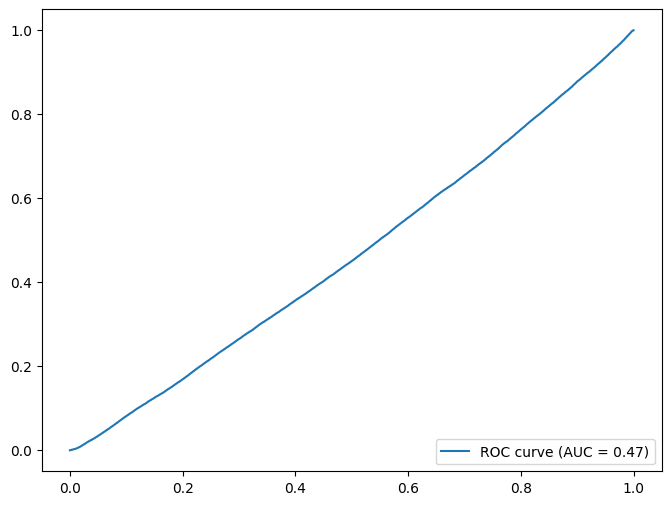

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.legend(loc="lower right")
plt.show()

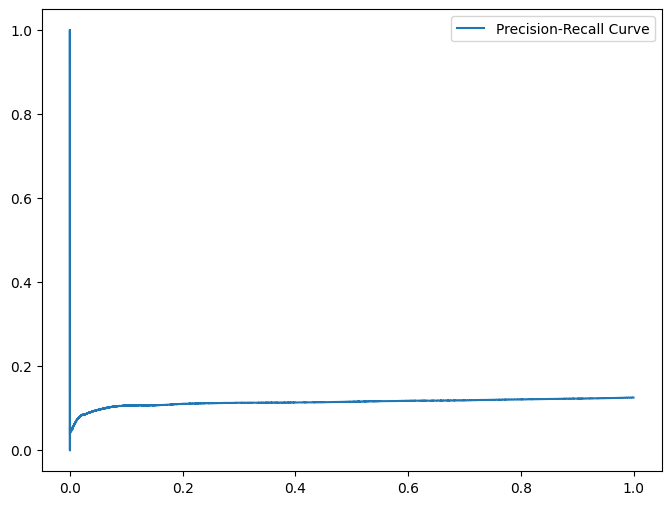

In [28]:
# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.legend()
plt.show()

## 7. Generate Recommendations

In [29]:
import shap

# Sample 500 rows for faster SHAP computation
X_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)

# SHAP Calculation (Much Faster on Sample)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)  # Compute SHAP only on sample

# Feature importance extraction
feature_importance = pd.DataFrame(
    list(zip(X_sample.columns, np.abs(shap_values).mean(axis=0))),
    columns=['Feature', 'SHAP Importance']
).sort_values(by='SHAP Importance', ascending=False)

top_features = feature_importance.head(5)

# Display key risk factors based on SHAP values
print("🔴 **Key Risk Factors Contributing to Loan Default:**")
for i, row in top_features.iterrows():
    print(f"{i+1}. {row['Feature']} (SHAP Importance: {row['SHAP Importance']:.4f})")

🔴 **Key Risk Factors Contributing to Loan Default:**
14. income_to_loan_ratio (SHAP Importance: 0.2395)
13. installment (SHAP Importance: 0.0696)
12. mort_acc (SHAP Importance: 0.0478)
1. loan_amnt (SHAP Importance: 0.0398)
2. term (SHAP Importance: 0.0377)


In [30]:
# Static key risk factors
print("\n📌 **General Risk Indicators:**")
print("✔ High Debt-to-Income Ratio (DTI > 20)")
print("✔ Low FICO Score (FICO < 650)")
print("✔ High Revolving Utilization (Utilization > 60%)")
print("✔ Large Loan Amounts (Loan > $25k)")

# Lender Recommendations
print("\n💡 **Lender Policy Recommendations:**")
print("1️⃣ Implement **stricter DTI thresholds** for high-risk categories (DTI > 20)")
print("2️⃣ Offer **lower interest rates** for borrowers with FICO > 700 to reduce default risk")
print("3️⃣ Add **credit counseling** requirements for borrowers with utilization > 75%")
print("4️⃣ Consider **income-to-loan ratio** as an additional qualification metric")
print("5️⃣ Limit large loans for borrowers with **low credit scores & high DTI**")


📌 **General Risk Indicators:**
✔ High Debt-to-Income Ratio (DTI > 20)
✔ Low FICO Score (FICO < 650)
✔ High Revolving Utilization (Utilization > 60%)
✔ Large Loan Amounts (Loan > $25k)

💡 **Lender Policy Recommendations:**
1️⃣ Implement **stricter DTI thresholds** for high-risk categories (DTI > 20)
2️⃣ Offer **lower interest rates** for borrowers with FICO > 700 to reduce default risk
3️⃣ Add **credit counseling** requirements for borrowers with utilization > 75%
4️⃣ Consider **income-to-loan ratio** as an additional qualification metric
5️⃣ Limit large loans for borrowers with **low credit scores & high DTI**
